# Statistical Parameter Estimation 2024
## Exercise 4

Author: Alex Karonen

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

First realisations (zero mean, squared exponential kernel)

In [19]:
# Squared exponential covariance kernel

def sqexp_kernel(t, tp,theta):
    return theta[0] * np.exp(-0.5 * (t-tp)**2/theta[1]**2)

# predictive conditional distribution

def GP_predict(t, params, kernel, mean = None, points=None):
    if points is None:
        x = np.array([0.5])
        y = np.random.normal(scale=params[0]/2, size=x.shape)

    else:
        x = points[0, :]
        y = points[1, :]

    n_star = len(t)
    n = len(x)

    A = np.empty((n, n)) # C(t,t)
    for i in range(n):
        for j in range(i, n):
            A[i, j] = kernel(x[i], x[j], params)
            A[j, i] = A[i, j]

    B = np.empty((n_star, n_star)) # C(t*, t*)
    for i in range(n_star):
        for j in range(i, n_star):
            B[i, j] = kernel(t[i], t[j], params)
            B[j, i] = B[i, j]

    C = np.empty((n_star, n)) # C(t*, t)
    for i in range(n_star):
        for j in range(n):
            C[i, j] = kernel(t[i], x[j], params)


    if mean is not None:
        mu = mean(x)
        mu_star = mean(t)
        mean_C = C @ np.linalg.inv(A) @ (y-mu) + mu_star
        cov_C = B - C @ np.linalg.inv(A) @ C.T
    else:
        mean_C = C @ np.linalg.inv(A) @ y 
        cov_C = B - C @ np.linalg.inv(A) @ C.T

    samples = np.random.multivariate_normal(mean=mean_C, cov=cov_C)

    return samples


In [20]:
t = np.linspace(0, 1, 200)

s = 2
ell = 0.2
theta = [s, ell]

N_reals=1000

preds = np.empty((len(t), N_reals))
for n in range(N_reals):
    p = GP_predict(t, theta, sqexp_kernel)
    preds[:,n] = p


mu_0 = np.zeros_like(t)
err = [mu_0 + s, mu_0 - s]

cond_preds = np.empty((len(t), N_reals))

for n in range(N_reals):
    x = [ 0.2, 0.5, 0.8]
    y = [0, 1, -1]
    p = GP_predict(t, theta, sqexp_kernel, points=np.vstack((x, y)))
    cond_preds[:, n] = p


err_cond = [
    np.mean(cond_preds, axis=1) + 2*np.std(cond_preds, axis=1),
    np.mean(cond_preds, axis=1) - 2*np.std(cond_preds, axis=1),
]

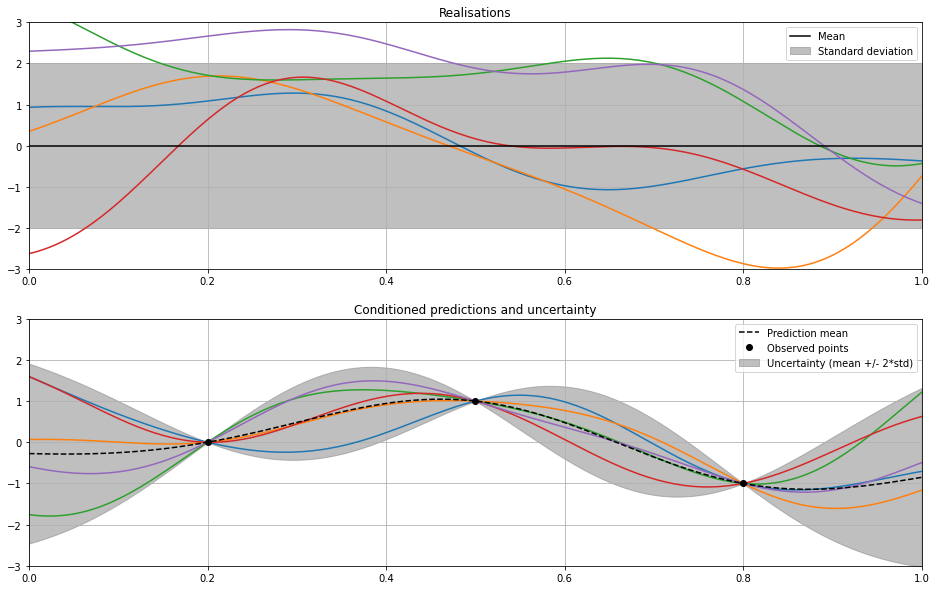

In [21]:
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.plot(t, preds[:,:5])
plt.plot(t, mu_0, 'k', label="Mean")
plt.fill_between(t, err[0], err[1],  color='gray', alpha=0.5, label="Standard deviation")
plt.title("Realisations")
plt.ylim([-3, 3])
plt.xlim([0, 1])
plt.legend()
plt.grid()


plt.subplot(212)
plt.plot(t, cond_preds[:,:5])
plt.plot(t, np.mean(cond_preds, axis=1), 'k--', label='Prediction mean')
plt.plot(x, y, 'ko', label='Observed points')
plt.fill_between(t, err_cond[0], err_cond[1], color="gray", alpha=0.5, label='Uncertainty (mean +/- 2*std)')
plt.title("Conditioned predictions and uncertainty")
plt.ylim([-3,3])
plt.xlim([0, 1])
plt.legend()
plt.grid()

plt.show()

Second realisation (zero mean and exponential kernel and noisy model)

In [22]:
def exp_kernel(t,tp, theta):
    return theta[0] * np.exp(-0.5 * np.abs(t-tp)/ theta[1])


In [23]:


s = 2
ell = 0.2
theta = [s, ell]



preds = np.empty((len(t), N_reals))
for n in range(N_reals):
    p = GP_predict(t, theta, exp_kernel)
    preds[:, n] = p


mu_0 = np.zeros_like(t)
err = [mu_0 + s, mu_0 - s]

cond_preds = np.empty((len(t), N_reals))

for n in range(N_reals):

    x = [0.2, 0.5, 0.8]
    y = [0, 1, -1]
    p = GP_predict(t, theta, exp_kernel, points=np.vstack((x, y)))
    cond_preds[:, n] = p

upper = np.mean(cond_preds, axis=1) + 2 *np.std(cond_preds, axis=1)
lower = np.mean(cond_preds, axis=1) - 2 * np.std(cond_preds, axis=1)

err_cond = [upper, lower]

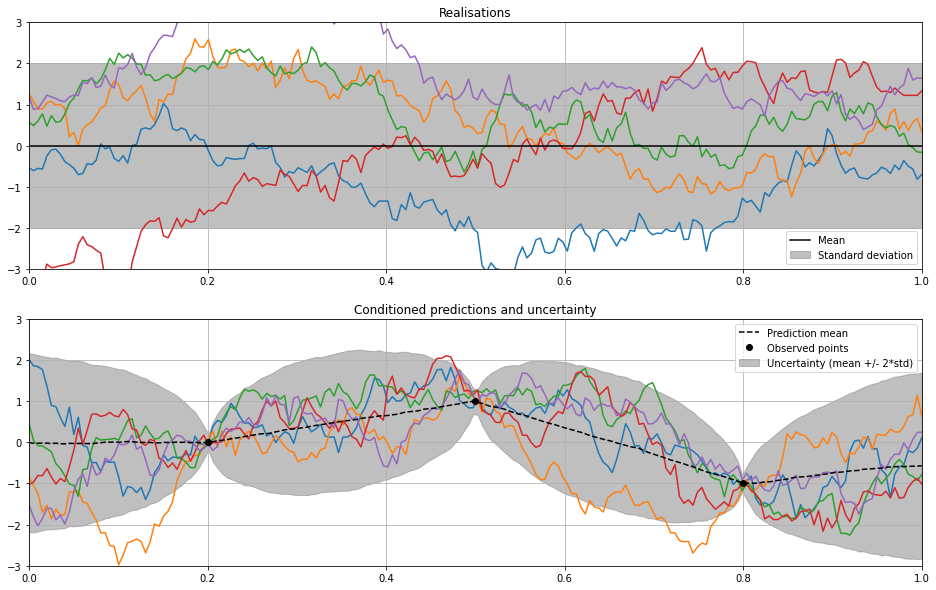

In [24]:
plt.figure(figsize=(16, 10))
plt.subplot(211)
plt.plot(t, preds[:, :5])
plt.plot(t, mu_0, "k", label="Mean")
plt.fill_between(t, err[0], err[1], color="gray", alpha=0.5, label="Standard deviation")
plt.title("Realisations")
plt.ylim([-3, 3])
plt.xlim([0, 1])
plt.legend()
plt.grid()


plt.subplot(212)
plt.plot(t, cond_preds[:, :5])
plt.plot(t, np.mean(cond_preds, axis=1), "k--", label="Prediction mean")
plt.plot(x, y, "ko", label="Observed points")
plt.fill_between(
    np.linspace(0,1, len(err_cond[0])),
    err_cond[0],
    err_cond[1],
    color="gray",
    alpha=0.5,
    label="Uncertainty (mean +/- 2*std)",
)
plt.title("Conditioned predictions and uncertainty")
plt.ylim([-3, 3])
plt.xlim([0, 1])
plt.legend()
plt.grid()

plt.show()

With linear mean

In [25]:
t = np.linspace(0, 1, 200)

s = 2
ell = 0.2
theta = [s, ell]

mu = lambda x: -5+10*x


preds = np.empty((len(t), N_reals))
for n in range(N_reals):
    p = GP_predict(t, theta, sqexp_kernel, mean=mu)
    preds[:,n] = p


mu_0 = np.zeros_like(t)
err = [mu(t) + s, mu(t) - s]


cond_preds = np.empty((len(t), N_reals))

for n in range(N_reals):
    x = [ 0.2, 0.5, 0.8]
    y = [0, 1, -1]
    p = GP_predict(t, theta, sqexp_kernel, points=np.vstack((x, y)), mean=mu)
    cond_preds[:, n] = p


err_cond = [
    np.mean(cond_preds, axis=1) + 2*np.std(cond_preds, axis=1),
    np.mean(cond_preds, axis=1) - 2*np.std(cond_preds, axis=1),
]

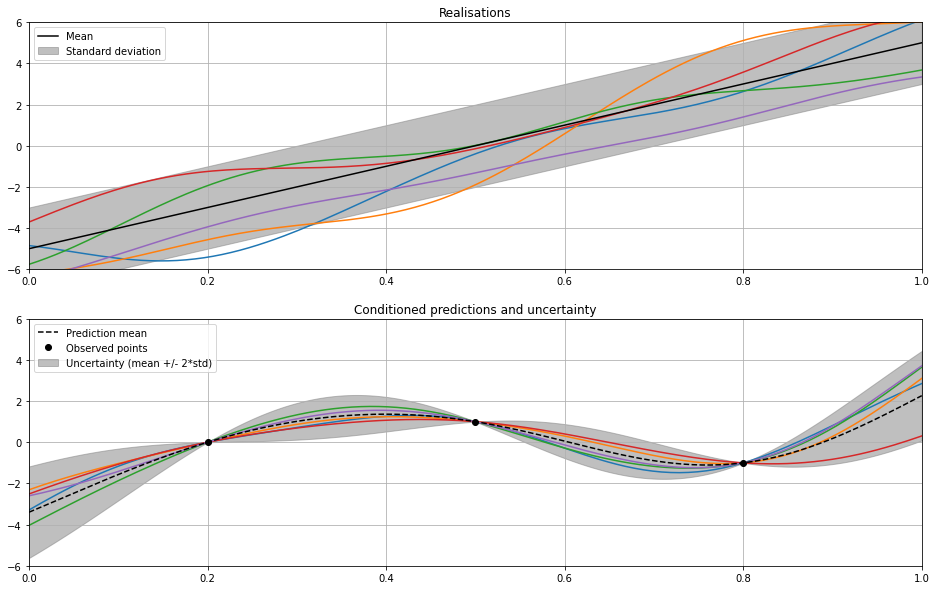

In [26]:
plt.figure(figsize=(16, 10))


plt.subplot(211)

plt.plot(t, preds[:, :5])
plt.plot(t, mu(t), "k", label="Mean")
plt.fill_between(t, err[0], err[1], color="gray", alpha=0.5, label="Standard deviation")
plt.title("Realisations")
plt.ylim([-6, 6])
plt.xlim([0, 1])
plt.legend()
plt.grid()



plt.subplot(212)


plt.plot(t, cond_preds[:, :5])

plt.plot(t, np.mean(cond_preds, axis=1), "k--", label="Prediction mean")
plt.plot(x, y, "ko", label="Observed points")
plt.fill_between(
    np.linspace(0, 1, len(err_cond[0])),
    err_cond[0],
    err_cond[1],
    color="gray",
    alpha=0.5,

    label="Uncertainty (mean +/- 2*std)",
)

plt.title("Conditioned predictions and uncertainty")

plt.ylim([-6, 6])
plt.xlim([0, 1])
plt.legend()
plt.grid()

plt.show()